In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp 

tfd = tfp.distributions

[*********************100%***********************]  1 of 1 completed


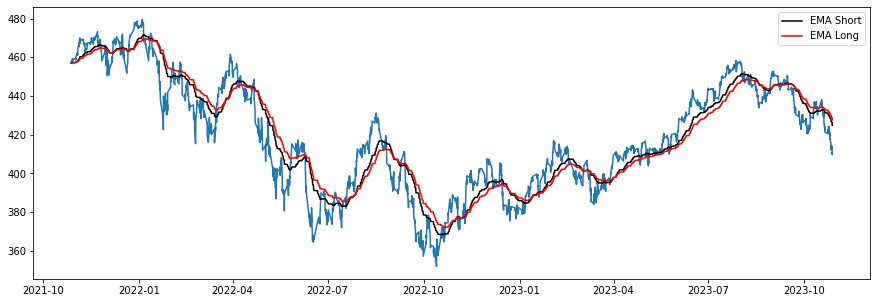

In [2]:
#downlaod data
df = yf.download('SPY', interval = '1h', period = '2y')

#reset index
df = df.reset_index()

#rename the index column to Date
df.rename(columns = {'index': 'Date'}, inplace = True)

orig_columns = list(df.columns)
lower_orig_columns = [x.lower() for x in orig_columns]

for i, column_name in enumerate(lower_orig_columns):
    df.rename(columns = {f'{orig_columns[i]}': f'{column_name}'}, inplace = True)

#create sma
df['sma'] = df['close'].rolling(60).mean()

#create two emas short and long
df['emas'] = df['close'].ewm(60, adjust = False).mean()
df['emal'] = df['close'].ewm(90, adjust = False).mean()


#plot the results
plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.plot(df['date'], df['emas'], c = 'k', label = 'EMA Short')
plt.plot(df['date'], df['emal'], c = 'r', label = 'EMA Long')
plt.legend()
plt.show()

In [3]:
#create min and maximas 
df = utils.create_targets(df, target_winloss = [20, 0])

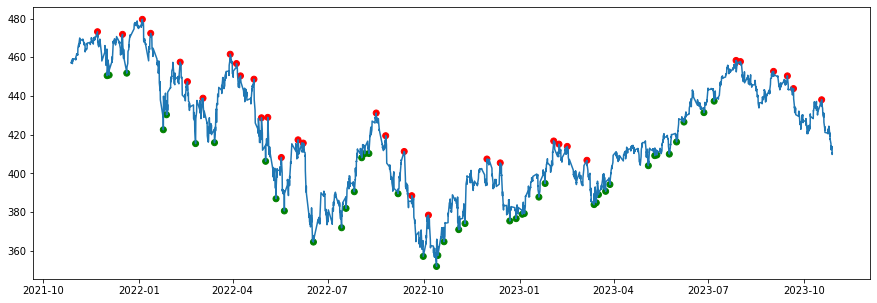

In [4]:
#plot
#plot the results
colors = {0: 'None', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['target'].apply(lambda x: colors[x]))
plt.show()

In [5]:
#generate trends to create labels for trending up, trending down and neutral areas

def generate_trends(data):
    
    data['trend'] = 0

    targets = data['target'].values

    min_indices = np.where(targets == 1)[0]

    max_indices = np.where(targets == 2)[0]

    ind_dict = {}

    for i in min_indices:
        ind_dict[i] = 1

    for i in max_indices:
        ind_dict[i] = 2

    sorted_dict = {k: ind_dict[k] for k in sorted(ind_dict)}

    current_ind = next(iter(sorted_dict))
    current_trend = sorted_dict[current_ind]


    for i, trend in sorted_dict.items():

        if current_trend == trend:
            continue
        elif (current_trend == 1) and (trend == 2):
            data.loc[current_ind:i, 'trend'] = 1
            current_ind = i
            current_trend = trend
        elif (current_trend == 2) and (trend == 1):
            data.loc[current_ind:i, 'trend'] = 2
            current_ind = i
            current_trend = trend
            
    return data['trend'].to_list()

<Figure size 1080x216 with 0 Axes>

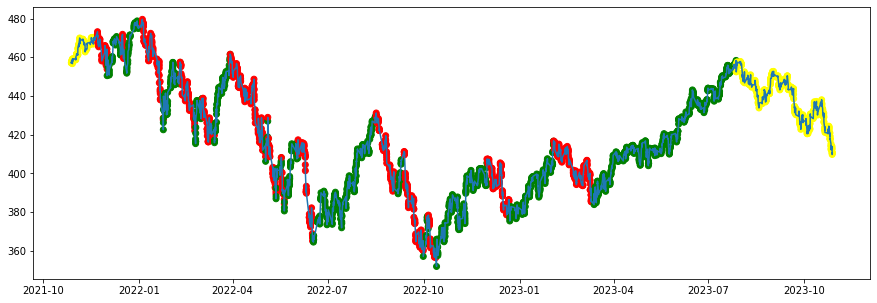

In [6]:
#create trend data and plot them
df['trend'] = np.nan
df['trend'] = generate_trends(df)

#pplot
plt.figure(figsize = (15, 3))

data_plot = df
colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(data_plot['date'], data_plot['close'])
plt.scatter(data_plot['date'], data_plot['close'], c = data_plot['trend'].apply(lambda x: colors[x]))
plt.show()

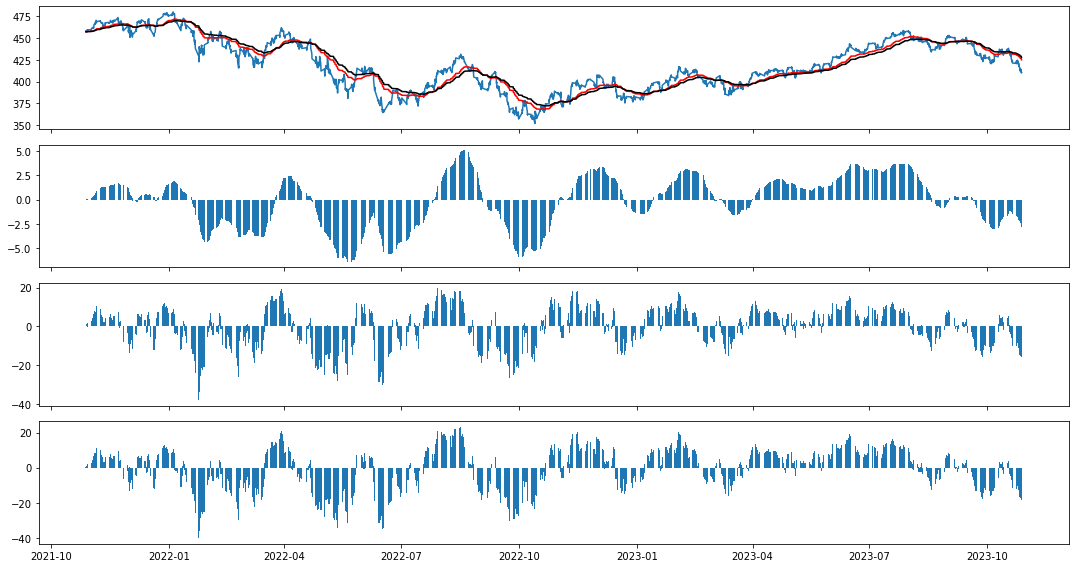

In [7]:
#create ema diffs and plot them
df['ma_diff'] = df['emas'] - df['emal']
df['cps_diff'] = df['close'] - df['emas']
df['cpl_diff'] = df['close'] - df['emal']

#plot the data to visualize
plot_data = df

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex = True, figsize = (15, 8))
ax1.plot(plot_data['date'], plot_data['close'])
ax1.plot(plot_data['date'], plot_data['emas'], color = 'r')
ax1.plot(plot_data['date'], plot_data['emal'], color = 'k')
ax2.bar(plot_data['date'], plot_data['ma_diff'])
ax3.bar(plot_data['date'], plot_data['cps_diff'])
ax4.bar(plot_data['date'], plot_data['cpl_diff'])
plt.tight_layout()
plt.show()

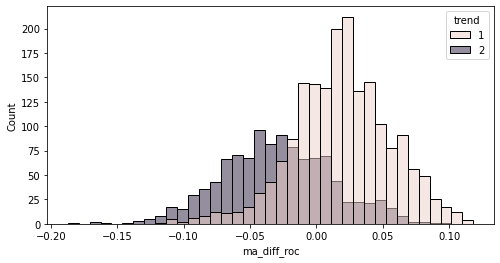

In [9]:
#create new variable ma difference rate of change 
df['ma_diff_roc'] = df['ma_diff'].diff()

#plot the data in hist
plt.figure(figsize = (8, 4))
sns.histplot(x = 'ma_diff_roc', data = df[df['trend'] != 0], hue = 'trend')
plt.show()

### Using a Mixture Model to predict the trend

Let's use tensorflow probability to build the model.

In [70]:
#arrange data 
data = df['ma_diff_roc'].dropna()
data_inds = data.index #indices for later use

#data as tf constant 
data = tf.constant(data, dtype = tf.float32)


In [71]:
# Initial values for means and scales
mu1 = tf.Variable(-0.04, dtype=tf.float32, name="mu1")
scal1 = tf.Variable(0.01, dtype=tf.float32, name="scal1")
mu2 = tf.Variable(0.02, dtype=tf.float32, name="mu2")
scal2 = tf.Variable(0.01, dtype=tf.float32, name="scal2")

#create a categorical distribution for the probabilities
p = tf.Variable([0.5, 0.5], dtype = tf.float32, name = 'probs')
p1 = tf.Variable(tf.nn.softmax(p), name = 'prob1')
cat_dist = tfd.Categorical(probs = p1)

#mixture model
components = [tfd.Normal(mu1, scal1), tfd.Normal(mu2, scal2)]
mixture_model = tfd.Mixture(cat=cat_dist, components=components)

#negative log likelihood
def negative_log_likelihood(data):
    return -tf.reduce_mean(mixture_model.log_prob(data))

optimizer = tf.optimizers.Adam(learning_rate = 0.01)

for i in range(1000):
    with tf.GradientTape() as tape:
        tape.watch([p1, mu1, scal1, mu2, scal2])
        loss = negative_log_likelihood(data)
        
    gradients = tape.gradient(loss, [p1, mu1, scal1, mu2, scal2])
    optimizer.apply_gradients(zip(gradients, [p1, mu1, scal1, mu2, scal2]))

In [72]:
#trained variables
for v in mixture_model.trainable_variables:
    print(f'{v.name}: {v.numpy()}')

prob1:0: [0.5461547  0.47604734]
mu1:0: 0.017163550481200218
scal1:0: 0.034940753132104874
mu2:0: -0.021419012919068336
scal2:0: 0.04235538840293884


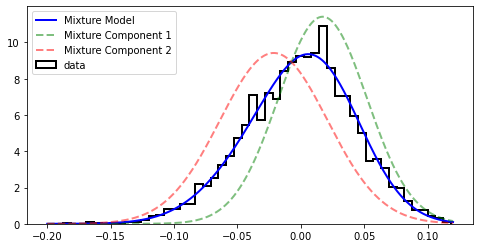

In [74]:
#plot the results
x = tf.linspace(-0.20, 0.12, 1000)

plt.figure(figsize = (8, 4))
plt.hist(data.numpy(), histtype="step", bins = 50, color = 'k', lw = 2, density = True, label = 'data')
plt.plot(x, mixture_model.prob(x), c = 'b', lw = 2, label = "Mixture Model")
plt.plot(x, mixture_model.components[0].prob(x), c = 'g', linestyle = '--', lw = 2, label = "Mixture Component 1", alpha = 0.5)
plt.plot(x, mixture_model.components[1].prob(x), c = 'r', linestyle = '--', lw = 2, label = "Mixture Component 2", alpha = 0.5)
plt.legend()
plt.show()

In [38]:
#predictions from model
buy_component = mixture_model.components[1].log_prob(data)
sell_component = mixture_model.components[0].log_prob(data)

#find preds
preds = [1 if x < y else 2 for (x, y) in zip(buy_component, sell_component)]

#append the preds to the dataframe
df['mixture_preds'] = 0
df.loc[data_inds, 'mixture_preds'] = preds

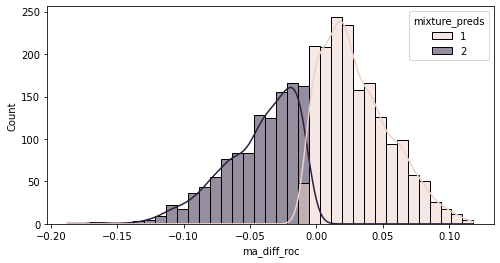

In [52]:
#results with preds
plt.figure(figsize = (8, 4))
sns.histplot(x = 'ma_diff_roc', data = df[df['trend'] != 0], hue = 'mixture_preds', kde = True)
plt.show()

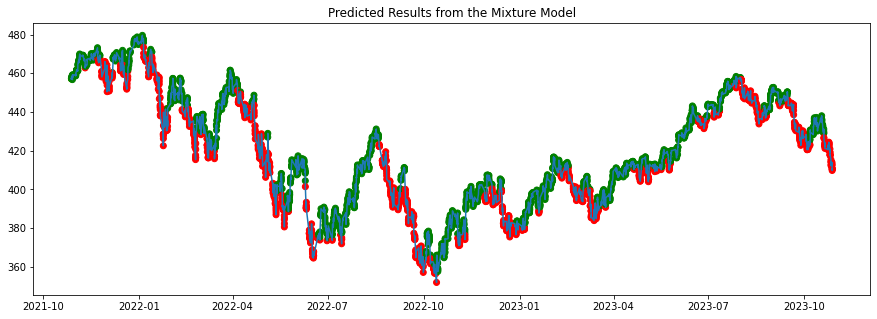

In [53]:
#plot results from the model
data_plot = df

colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.title('Predicted Results from the Mixture Model')
plt.plot(data_plot['date'], data_plot['close'])
plt.scatter(data_plot['date'], data_plot['close'], c = data_plot['mixture_preds'].apply(lambda x: colors[x]))
plt.show()

In [54]:
#find the accuracy of the prediction from the method
from sklearn.metrics import accuracy_score

true_labels = df['trend'].to_list()
predicted_labels = df['mixture_preds'].to_list()

print(f"accuracy score: {accuracy_score(true_labels, predicted_labels)}")

accuracy score: 0.6291654799202506


### Repeating with sklearn Gaussian Mixture Model (GMM)

In [65]:
from sklearn.mixture import GaussianMixture

data = df['ma_diff_roc'].dropna()
data_inds = data.index

X_train = data.to_numpy().reshape(-1, 1)

# Train a GMM on the scaled training data
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

#predict using the model
y_pred = gmm.predict(X_train)

#append to the dataframe
df.loc[data_inds, 'gmm_preds'] = y_pred


#make the zeros 2's because 2 is a sell trend in the previous example
df['gmm_preds'] = [1 if x == 1 else 2 if x == 0 else 0 for x in df['gmm_preds']]

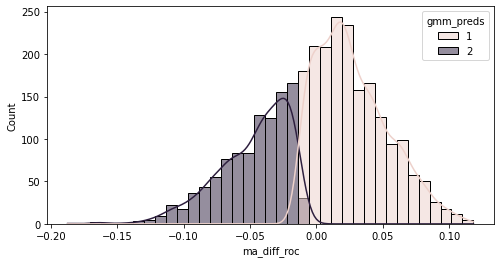

In [66]:
#plot results
colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (8, 4))
sns.histplot(x = 'ma_diff_roc', data = df[df['trend'] != 0], hue = 'gmm_preds', kde = True)
plt.show()

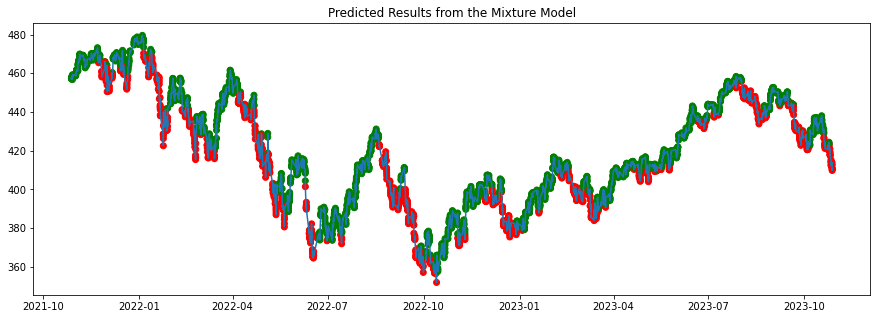

In [67]:
#plot results
data_plot = df

colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.title('Predicted Results from the Mixture Model')
plt.plot(data_plot['date'], data_plot['close'])
plt.scatter(data_plot['date'], data_plot['close'], c = data_plot['gmm_preds'].apply(lambda x: colors[x]))
plt.show()

In [68]:
#find the accuracy of the prediction from the method
from sklearn.metrics import accuracy_score

true_labels = df[df['trend'] != 0]['trend'].to_list()
predicted_labels = df[df['trend'] != 0]['gmm_preds'].to_list()

print(f"accuracy score: {accuracy_score(true_labels, predicted_labels)}")

accuracy score: 0.767394270122783
